# Anomaly Detection: From Decision Tree to Generative Model 
**Author**: Jeremy Vachier\
**Date**: 2024

Anamaly detection plays an important role in predictive maintenance. Often anomalies are particularly difficult to identify. In this notebook, different models are compared
1) Isolation Forest
2) AutoEncoders: \
    a- Deep Neural Network \
    b- Recurrent Neural Network (LSTM)
3) Variational AutoEncoder: Recurrent Neural Network (LSTM)

Also available on my Kaggle profile: \
https://www.kaggle.com/jvachier/anomaly-detection

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler

import keras
import tensorflow as tf 
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras.models import Model 
from tensorflow.keras.optimizers.legacy import Adam

# CPU & GPU

In [2]:
devices = tf.config.list_logical_devices()
print(devices)
gpus = tf.config.list_physical_devices('GPU')
details = tf.config.experimental.get_device_details(gpus[0])
print("GPU details: ", details)
tf.config.set_soft_device_placement(True)

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


# Loading Data

In [3]:
sensor_Data = pd.read_csv('./data/PdM_telemetry.csv')
failure = pd.read_csv('./data/PdM_failures.csv')

# Data Processing

In [4]:
sensor_Data['datetime'] = pd.to_datetime(sensor_Data["datetime"])
failure['datetime'] = pd.to_datetime(failure["datetime"])

sensor_Data.rename(columns={"datetime": "time"},inplace=True)
failure.rename(columns={"datetime": "time"},inplace=True)

failure.loc[failure["failure"] != 0, "failure"] = 1
failure["failure"] = failure["failure"].astype("int64")

sensor_Data.set_index('time',inplace=True)
failure.set_index('time',inplace=True)

# Select a Machine

In [5]:
machine_name = 10

In [6]:
sensor_Data = sensor_Data.query("machineID == @machine_name")
failure = failure.query("machineID == @machine_name")

# Different Models

1) Isolation Forest
2) AutoEncoders: \
    a- Deep Neural Network \
    b- Recurrent Neural Network (LSTM)
3) Variational AutoEncoder: Recurrent Neural Network (LSTM)

## 1) Isolation Forest

In [7]:
sensor_Data_machine = sensor_Data.copy()
sensor_Data_machine.drop(columns='machineID', inplace=True)

In [8]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(sensor_Data_machine.values)
data = pd.DataFrame(np_scaled)

In [9]:
model_time_series_t =  IsolationForest()
model_time_series_t.fit(data.values)

sensor_Data_machine['anomaly'] = model_time_series_t.predict(data.values)

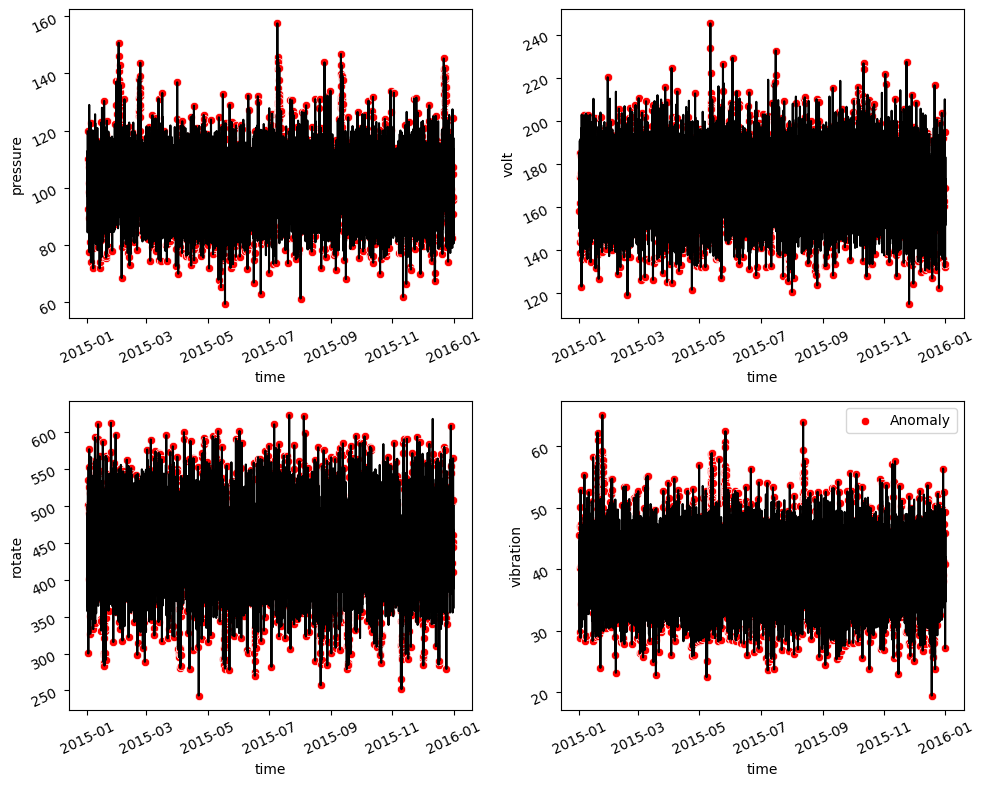

In [10]:
volt = sensor_Data.loc[sensor_Data_machine['anomaly'] == -1, ['volt']] #anomaly
pressure = sensor_Data.loc[sensor_Data_machine['anomaly'] == -1, ['pressure']] #anomaly
vibration = sensor_Data.loc[sensor_Data_machine['anomaly'] == -1, ['vibration']] #anomaly
rotate = sensor_Data.loc[sensor_Data_machine['anomaly'] == -1, ['rotate']] #anomaly


# create the time series subplots 
fig,ax =  plt.subplots( 2, 2, 
                       figsize = ( 10, 8)) 
  
sns.lineplot( x = sensor_Data_machine.index, y = "pressure",  
             color = 'k', data = sensor_Data_machine,  
             ax = ax[0][0]) 
sns.scatterplot(x = pressure.index, y = 'pressure',
                color='r', data = pressure, 
                ax = ax[0][0]) 

ax[0][0].tick_params(labelrotation = 25) 
sns.lineplot( x = sensor_Data_machine.index, y = "volt",  
             color = 'k', data = sensor_Data_machine, 
             ax = ax[0][1]) 
sns.scatterplot(x = volt.index, y = 'volt',
                color='r', data = volt, 
                ax = ax[0][1])
  
ax[0][1].tick_params(labelrotation = 25) 
sns.lineplot(x = sensor_Data_machine.index, y = "rotate",  
             color = 'k', data = sensor_Data_machine, 
             ax = ax[1][0]) 
sns.scatterplot(x = rotate.index, y = 'rotate',
                color='r', data = rotate, 
                ax = ax[1][0])


ax[1][0].tick_params(labelrotation = 25)   
sns.lineplot(x = sensor_Data_machine.index, y = "vibration",  
             color = 'k', data = sensor_Data_machine,
             ax = ax[1][1]) 
sns.scatterplot(x = vibration.index, y = 'vibration',
                color='r', data = vibration, label = 'Anomaly',
                ax = ax[1][1])


ax[1][1].tick_params(labelrotation = 25) 
fig.tight_layout(pad = 1.2) 

## Functions for AutoEncoder

In [11]:
time_step = 50
def create_sequences(values: list) -> np.array:
    output = []
    for i in range(len(values) - time_step + 1):
        output.append(values[i : (i + time_step)])
    return np.stack(output)

In [12]:
def result_autocendoer(model: object, x_train: np.array) -> tf.Tensor:
    # Calculate the reconstruction error for each data point
    reconstructions_deep = model.predict(x_train)
    mse = tf.reduce_mean(tf.square(x_train - reconstructions_deep), axis=[1, 2])
    return mse

In [13]:
def visualization(sensor_Data_machine: pd.DataFrame,
                  anomalous: pd.Series, time_step: int)->None:
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    axs[0, 0].plot(
        sensor_Data_machine.index,
        sensor_Data_machine[['pressure']],
        "k",
    )
    axs[0, 0].plot(
        sensor_Data_machine.index[(time_step - 1) :][anomalous],
        sensor_Data_machine[['pressure']][(time_step - 1) :][anomalous],
        "ro",
    )
    axs[0, 0].set_ylabel("Pressure")
    axs[0, 0].tick_params(labelrotation = 25) 

    axs[1, 0].plot(
        sensor_Data_machine.index,
        sensor_Data_machine[['rotate']],
        "k",
    )
    axs[1, 0].plot(
        sensor_Data_machine.index[(time_step - 1) :][anomalous],
        sensor_Data_machine[['rotate']][(time_step - 1) :][anomalous],
        "ro",
    )
    axs[1, 0].set_ylabel("Rotate")
    axs[1, 0].tick_params(labelrotation = 25) 

    axs[0, 1].plot(
        sensor_Data_machine.index,
        sensor_Data_machine[['volt']],
        "k",
    )
    axs[0, 1].plot(
        sensor_Data_machine.index[(time_step - 1) :][anomalous],
        sensor_Data_machine[['volt']][(time_step - 1) :][anomalous],
        "ro",
    )

    axs[0, 1].set_ylabel("Volt")
    axs[0, 1].tick_params(labelrotation = 25) 

    axs[1, 1].plot(
        sensor_Data_machine.index,
        sensor_Data_machine[['vibration']],
        "k",
    )
    axs[1, 1].plot(
        sensor_Data_machine.index[(time_step - 1) :][anomalous],
        sensor_Data_machine[['vibration']][(time_step - 1) :][anomalous],
        "ro",
    )
    axs[1, 1].set_ylabel("Vibration")
    axs[1, 1].tick_params(labelrotation = 25) 
    fig.tight_layout(pad = 1.2) 

## 2) AutoEncoders
### a- Deep Neural Network

In [14]:
sensor_Data_machine = sensor_Data.copy()
sensor_Data_machine.drop(columns='machineID', inplace=True)

In [15]:
scaler_auto = StandardScaler() 
np_scaled = scaler_auto.fit_transform(sensor_Data_machine)
x_train = create_sequences(np_scaled)

In [16]:
with tf.device('/device:CPU:0'):   
    input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))
    encoded = Dense(128, activation="relu")(input_layer)
    encoded = Dense(64, activation="relu")(encoded)
    encoded = Dense(32, activation="relu")(encoded)

    decoded = Dense(64, activation="relu")(encoded)
    decoded = Dense(128, activation="relu")(decoded)
    decoded = Dense(x_train.shape[2], activation="relu")(decoded)

    # Compile and fit the model
    autoencoder_deep = Model(input_layer, decoded)
    autoencoder_deep.summary()
    autoencoder_deep.compile(
        optimizer=Adam(learning_rate=0.00001), loss="mse", metrics=["accuracy"]
    )
    autoencoder_deep.fit(
        x_train, x_train, epochs=10, batch_size=128, validation_split=0.1
    )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 4)]           0         
                                                                 
 dense (Dense)               (None, 50, 128)           640       
                                                                 
 dense_1 (Dense)             (None, 50, 64)            8256      
                                                                 
 dense_2 (Dense)             (None, 50, 32)            2080      
                                                                 
 dense_3 (Dense)             (None, 50, 64)            2112      
                                                                 
 dense_4 (Dense)             (None, 50, 128)           8320      
                                                                 
 dense_5 (Dense)             (None, 50, 4)             516   

In [17]:
mse = result_autocendoer(autoencoder_deep, x_train)

273/273 [==============================] - 2s 6ms/step


In [18]:
anomaly_deep_scores = pd.Series(mse.numpy(), name="anomaly_scores")
anomaly_deep_scores.index = sensor_Data_machine[(time_step - 1) :].index

In [19]:
threshold_deep = anomaly_deep_scores.quantile(0.98)
anomalous_deep = anomaly_deep_scores > threshold_deep

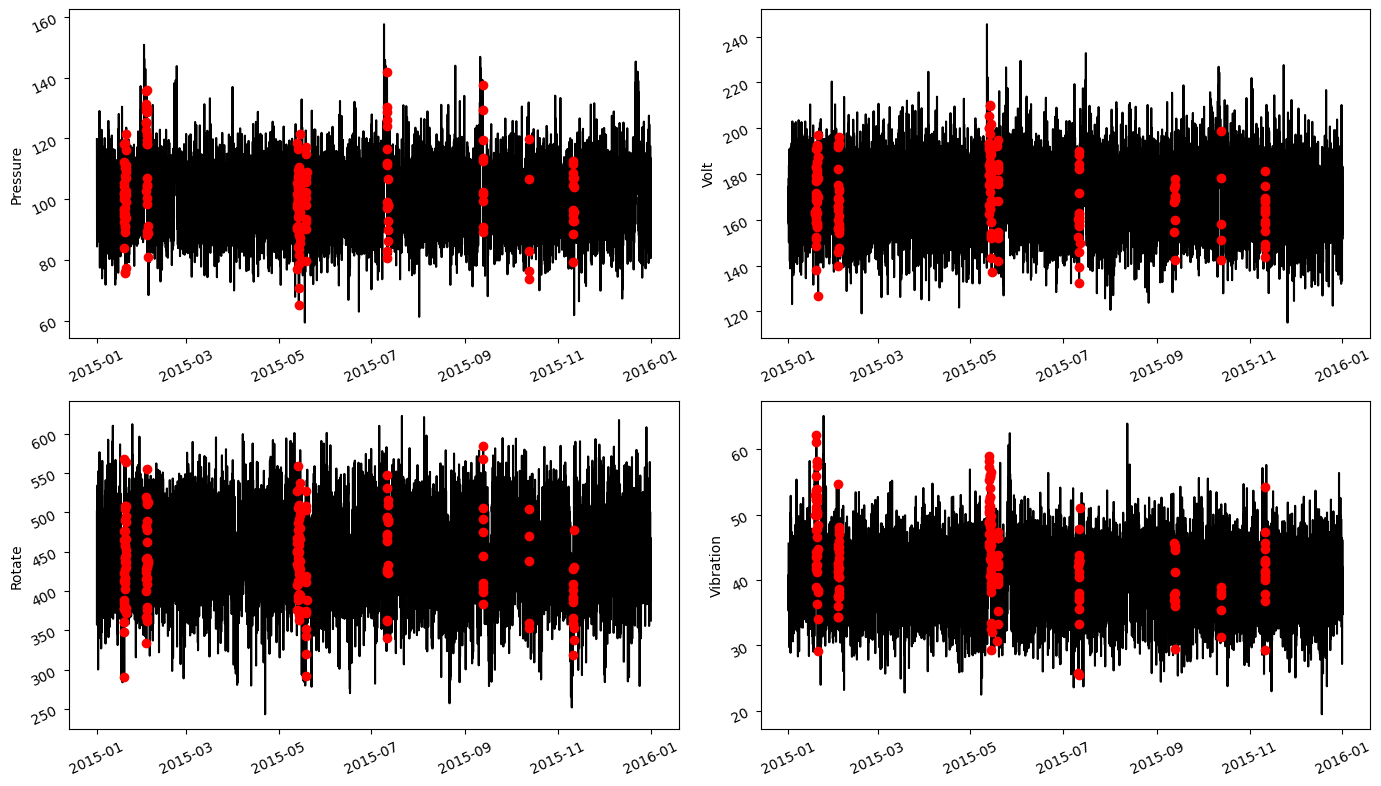

In [20]:
visualization(sensor_Data_machine,anomalous_deep, time_step)

### b- Recurrent Neural Network (LSTM)

In [21]:
sensor_Data_machine = sensor_Data.copy()
sensor_Data_machine.drop(columns='machineID', inplace=True)

In [22]:
scaler_auto_lstm = StandardScaler() 
np_scaled = scaler_auto_lstm.fit_transform(sensor_Data_machine)
x_train = create_sequences(np_scaled)

In [23]:
with tf.device('/device:GPU:0'):
    input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))
    encoded = LSTM(128, return_sequences=True)(input_layer)
    encoded_1 = LSTM(64, return_sequences=True)(encoded)
    encoded_2 = LSTM(32, return_sequences=True)(encoded_1)
    
    
    decoded = LSTM(32, return_sequences=True)(encoded_2)
    decoded_1 = LSTM(64, return_sequences=True)(decoded)
    decoded_2 = LSTM(128, return_sequences=True)(decoded_1)
    decoded_4 = TimeDistributed(Dense(x_train.shape[2], activation="relu"))(decoded_2)

    autoencoder_lstm = Model(input_layer, decoded_4)
    
    autoencoder_lstm.summary()
    autoencoder_lstm.compile(
    optimizer=Adam(
        learning_rate=0.00001), loss="mse", metrics=["accuracy"]
    )
    autoencoder_lstm.fit(
        x_train, x_train, epochs=10, batch_size=128, validation_split=0.1
    )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 4)]           0         
                                                                 
 lstm (LSTM)                 (None, 50, 128)           68096     
                                                                 
 lstm_1 (LSTM)               (None, 50, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 50, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 50, 32)            8320      
                                                                 
 lstm_4 (LSTM)               (None, 50, 64)            24832     
                                                                 
 lstm_5 (LSTM)               (None, 50, 128)           9881

In [24]:
mse = result_autocendoer(autoencoder_lstm, x_train)

273/273 [==============================] - 3s 8ms/step


In [25]:
anomaly_lstm_scores = pd.Series(mse.numpy(), name="anomaly_scores")
anomaly_lstm_scores.index = sensor_Data_machine[(time_step - 1) :].index

In [26]:
threshold_lstm = anomaly_lstm_scores.quantile(0.98)
anomalous_lstm = anomaly_lstm_scores > threshold_lstm

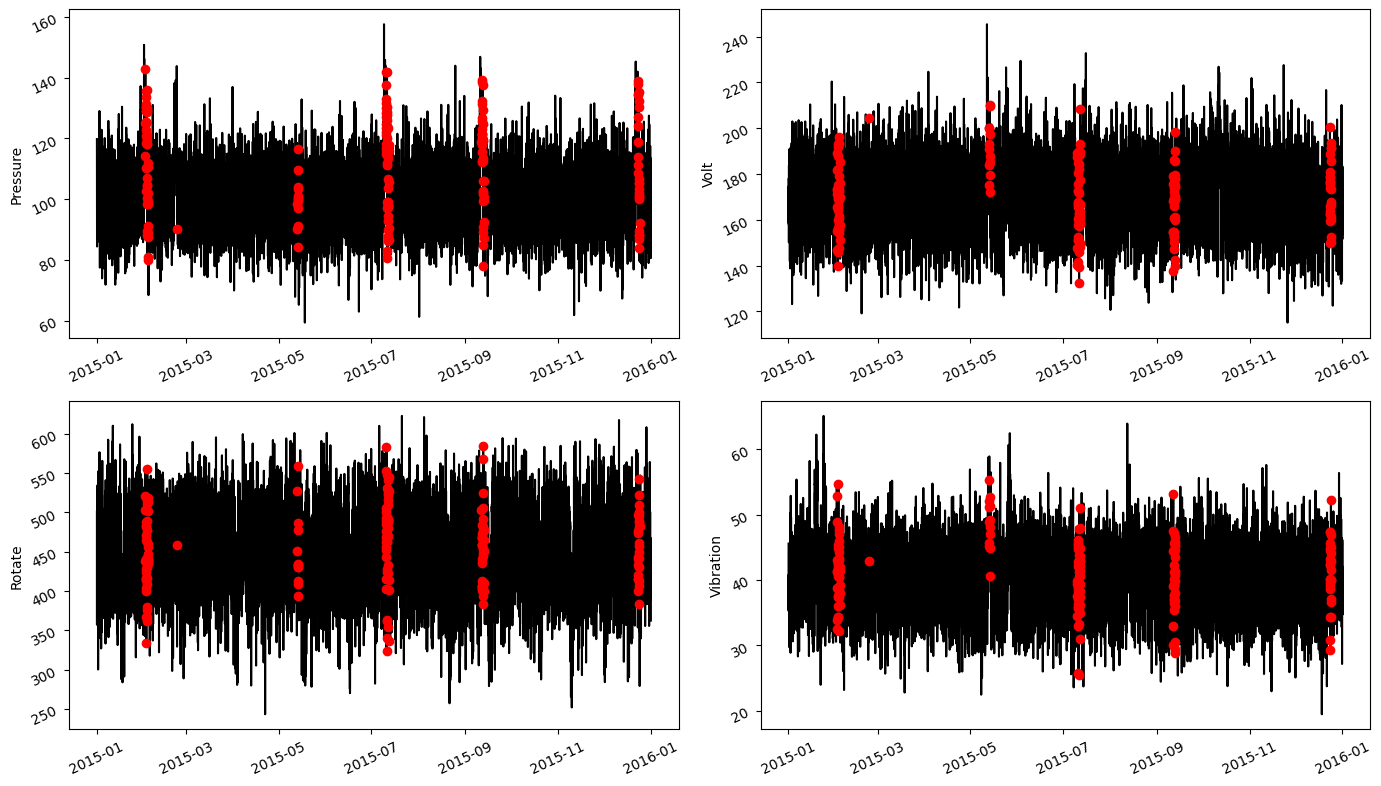

In [27]:
visualization(sensor_Data_machine,anomalous_lstm, time_step)

## 3) Variational AutoEncoder

In [28]:
def call(input1,input2):
    z_mean = input1
    z_log_var = input2
    batch = z_mean.shape[1]
    dim = z_mean.shape[2]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Parameters

In [29]:
sensor_Data_machine = sensor_Data.copy()
sensor_Data_machine.drop(columns='machineID', inplace=True)

In [30]:
scaler_auto_lstm = StandardScaler() 
np_scaled = scaler_auto_lstm.fit_transform(sensor_Data_machine)
x_train = create_sequences(np_scaled)

In [31]:
latent_dim = 2

## Model

In [32]:
with tf.device('/device:GPU:0'):
    # Encoder
    input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))


    encoded = LSTM(128, return_sequences=True)(input_layer)
    encoded_1 = LSTM(64, return_sequences=True)(encoded)
    encoded_2 = LSTM(32, return_sequences=True)(encoded_1)

    z_mean = Dense(latent_dim)(encoded_2)
    z_log_var = Dense(latent_dim)(encoded_2)
    z = call(z_mean, z_log_var)

    Encoder = Model(input_layer, [z_mean, z_log_var, z], name="encoder")
    Encoder.summary()

    # Decoder
    latent_inputs = Input(shape=(x_train.shape[1],latent_dim,))

    decoded = LSTM(32, return_sequences=True)(latent_inputs)
    decoded_1 = LSTM(64, return_sequences=True)(decoded)
    decoded_2 = LSTM(128, return_sequences=True)(decoded_1)
    decoded_3 = TimeDistributed(Dense(x_train.shape[2], activation="relu"))(decoded_2)

    Decoder = Model(latent_inputs, decoded_3, name="decoder")
    Decoder.summary()

    # VAE
    outputs = Decoder(Encoder(input_layer)[2])
    vae = Model(input_layer, outputs, name='vae')
    vae.summary()

    # Loss
    reconstruction_loss = keras.losses.binary_crossentropy(input_layer, outputs) 
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    # VAE compile and fit
    vae.compile(optimizer='adam')
    vae.fit(
        x_train,x_train, epochs=10, batch_size=128, validation_split=0.1
    )

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50, 4)]              0         []                            
                                                                                                  
 lstm_6 (LSTM)               (None, 50, 128)              68096     ['input_3[0][0]']             
                                                                                                  
 lstm_7 (LSTM)               (None, 50, 64)               49408     ['lstm_6[0][0]']              
                                                                                                  
 lstm_8 (LSTM)               (None, 50, 32)               12416     ['lstm_7[0][0]']              
                                                                                            

In [33]:
mse = result_autocendoer(vae, x_train)

273/273 [==============================] - 5s 10ms/step


In [34]:
anomaly_vae_scores = pd.Series(mse.numpy(), name="anomaly_scores")
anomaly_vae_scores.index = sensor_Data[(time_step - 1) :].index

In [35]:
threshold_vae = anomaly_vae_scores.quantile(0.98)
anomalous_vae = anomaly_vae_scores > threshold_vae

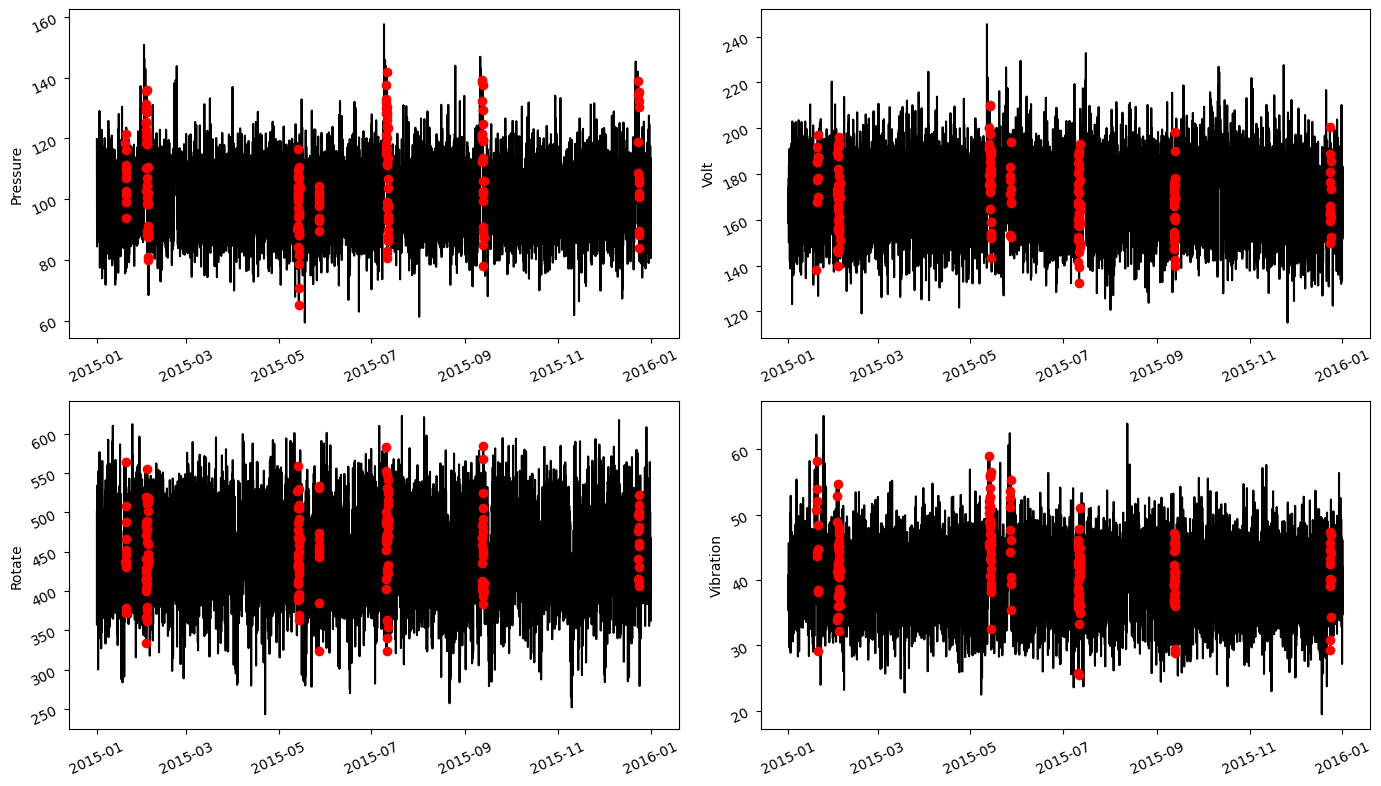

In [36]:
visualization(sensor_Data_machine,anomalous_vae, time_step)